In [1]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cluster,mixture
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import scipy

D:\python\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
d_ms = pd.read_csv('../example_data/clustering/sample1114.csv')

In [3]:
d_ms = d_ms.rename(columns={'Average Rt(min)': 'Average RT (min)', 'Average Mz': 'Average m/z', 'S/N average': 'Average sn'})
d_ms.insert(3, "Average score", 1)

In [4]:
keys=['CEC','Blank','ISTD','Wash','Shutdown']

In [38]:
d_ms[d_ms[d_ms.columns[4:]].max(1)>500000]

,Average RT (min),Average m/z,Average sn,Average score,20181114_CEC_CAL-8-no4_MSpos_1,20181114_CEC_CAL-8-no4_MSpos_2,20181114_CEC_CAL-8-no4_MSpos_3,20181114_CEC_CAL-8-no4_MSpos_4,20181114_CEC_CAL-8-no4_MSpos_5,20181114_CEC_CAL-8-no4_MSpos_6,...,20181114_SR520-Creek_Mix6A_3,20181114_SR520-Creek_Mix6B_1,20181114_SR520-Creek_Mix6B_2,20181114_SR520-Creek_Mix6B_3,20181114_SwanCreek-Dec_1,20181114_SwanCreek-Dec_2,20181114_SwanCreek-Dec_3,20181114_SwanCreek-May_1,20181114_SwanCreek-May_2,20181114_SwanCreek-May_3
9,3.405,102.12830,328.62,1,6047,6216,7131,6745,6503,6536,...,18224,14682,22262,13669,2787,6175,1592,3837,2359,913
18,0.669,104.10785,374.68,1,223176,226910,235522,236823,238360,233163,...,5605,11411,8035,8009,1951,1894,2223,6431,10595,5064
22,0.644,104.99271,577.07,1,233200,229447,230362,198524,217569,189061,...,28642,226131,230926,225655,33866,35298,32832,43295,40695,41093
49,16.068,117.11341,57.91,1,128170,160687,229006,181518,200239,132934,...,495954,521112,541949,540092,554232,582415,588641,447950,535279,545923
52,0.683,118.08663,272.63,1,7370,7228,7960,7591,7546,7353,...,5653,4653,6328,5506,1159,1775,1521,2502,2710,2275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,19.490,1342.92346,235.35,1,83788,76357,74787,127416,72634,72594,...,297777,76221,75888,75134,135323,76623,275350,444276,301790,81517
8478,19.278,1342.92725,6974.32,1,3807801,3661432,3723328,3706440,3633766,3651315,...,3402720,3800249,3728474,3822507,3020332,3320772,3714521,3038139,4266428,2964256
8480,19.400,1343.93115,2477.24,1,135437,132070,303690,129267,141729,137975,...,136193,151433,294404,150204,142682,151517,1219615,166109,171770,169611
8481,19.279,1347.88513,2814.96,1,1291113,1271331,1324830,1285122,1317570,1330792,...,1203983,1257752,1186746,1476320,1543501,1368572,1518216,1081798,1583138,1603928


In [116]:
def data_prep(d_input, blank_keyword, svb_thres=10, empty_thres=0, cv_thres=5,rt_range=[0, 30], mz_range=[0, 1200], sn_thres=3, score_thres=0, area_thres=5000):
    '''
    The function is used to clean the dataframe according to user setting
    blank_keyword: part of string from column that indicates the column is a blank sample
    svb_thres: sample vs blank thres
    empty_thres: empty cell thres in a row
    cv_thres: as all sample is in triplicate, calculate the CV for every triplicate sample set #Needs to be updated in case there is no triplicate samples
    rt_range: rt filter
    mz_range: mz filter
    sn_thres: signal/noise column thres
    score_thres: score column thres
    area_thres: count for max peak area from each row
    '''
    d_thres = d_input[d_input[d_input.columns[4:]].max(1) >= area_thres]
    
    d_thres = d_thres[(d_thres['Average RT (min)'] > rt_range[0]) & (d_thres['Average RT (min)'] < rt_range[1])]
    d_thres = d_thres[(d_thres['Average m/z'] > mz_range[0]) & (d_thres['Average m/z'] < mz_range[1])]
    d_thres = d_thres[d_thres['Average sn'] >= sn_thres]
    d_thres = d_thres[d_thres['Average score'] >= score_thres]
    d_thres.reset_index(inplace=True, drop=True)
    
    col_blank = []
    for key in blank_keyword:
        # Get column name if it contains blank indicating strings
        col_blank.extend([col for col in d_thres.columns if key in col])
        
    col_sample = [col for col in d_thres.columns if col not in col_blank]
    # Sample maximum area vs Blank average area to count for svb
    d_sample = d_thres[d_thres[col_sample[4:]].max(axis=1) / d_thres[col_blank].mean(axis=1) > svb_thres][col_sample] 
    d_sample.reset_index(inplace=True)
    d_sample.drop(columns=['index'],inplace=True)
    
    # Get a list of triplicate, every triplicate is in a sublist
    #Sample: [[a1,a2,a3],[b1,b2,b3]]
    #Note: the triplicate parsing is now only used '_' which needs update in the future
    trip_list = [list(i) for j, i in groupby(d_sample.columns[4:], lambda a: a.split('_')[:-1])] 
    trip_list = [i for i in trip_list if len(i)>=2] #filter out columns that is not in triplicate -- sample naming issue

    for triplicate in tqdm(trip_list):
        # DM: maybe use iterrtuples? iterrows has low efficiency and is not reccomended 
        for row in d_sample[triplicate].itertuples(): # Loop for every sets of triplicates
            if row[1:].count(0) > empty_thres:
                d_sample.loc[row.Index, triplicate] = 0 # if more than thres, then set all three values to 0
            elif np.mean(row[1:]) != 0:
                if np.std(row[1:]) / np.mean(row[1:]) > cv_thres:
                    d_sample.loc[row.Index, triplicate] = 0 #If delete or reduce all number to avg?
            else:
                pass
            
    d_sample = d_sample[~(d_sample[d_sample.columns[4:]]==0).all(1)] #clean rows with all 0
    
    return d_sample

In [105]:
d_sample = data_prep(d_ms,keys,rt_range = [1,30], mz_range = [200,800], area_thres=500)

100%|██████████| 35/35 [01:35<00:00,  2.73s/it]


In [120]:
def ms_cluster(d_input, select_keyword, normalization='linear', visual=False, d_reduce=True, d_reduce_method='tsne', perplexity=20, cluster_method='dbscan',eps=0.8,min_samples=10):
    '''
    Function for direct clustering:
    normalization method: linear, zscore, log
    d_reduce: if perform the dimension reduction algorithm, method: only tsne is avilable now
    perplexity: parameter for tsne
    cluster_method: dbscan, later will update optic and spectrum
    eps: parameter for dbscan, threshold of radius that used to count neighbours
    min_samples: general parameter for clustering, min neighbourhoods to be counted as a cluster
    '''
    col_select = []
    for key in select_keyword:
        col_select.extend([col for col in d_input.columns if key in col])
    d_clu = d_input[col_select]
    
    c_data = d_clu.values
    c_norm = []
    #Performs normalization
    np.seterr(divide='ignore', invalid='ignore') #silent the warning -- but divide by 0 still exist
    for row in c_data:
        if normalization == 'linear':
            c_norm.append(row/max(row))
        elif normalization == 'zscore':
            c_norm.append((row-np.mean(row))/np.std(row))
        elif normalization == 'log':
            row[row==0]=1
            c_norm.append(np.log10(row)/np.log10(max(row)))
        else:
            pass
    #Clean up dataframe
    c_norm = np.asarray(c_norm)
    d_norm = pd.DataFrame(c_norm)
    d_norm['index']=d_sample.index
    d_norm.set_index('index',inplace=True)
    d_norm.dropna(how='all',inplace=True)
    
    if d_reduce == True:
        if d_reduce_method == 'tsne':
            model = TSNE(learning_rate=100,perplexity=50,n_iter=1000) #Tune perplexity and n_iter
            transformed = model.fit_transform(d_norm)
            d_feature = transformed.copy()
        else:
            pass
    elif d_reduce == False:
        d_feature = d_norm.copy()
    else:
        pass
    
    if cluster_method == 'dbscan':
        dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(d_feature)
        labels = dbscan.labels_
        unique_labels = set(dbscan.labels_)
        
        if visual == True:
            for i,k in enumerate(unique_labels):
                indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
                sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False,figsize=(5,5))
                plt.title(str(dbscan)+'label='+ str(k))
                plt.show()
        else:
            pass
        d_init = d_sample.copy()
        d_label = d_init.loc[d_norm.index] #Use the index to match back to the original datasheet
        d_label.insert(4,"label", dbscan.labels_.tolist())
    elif cluster_method == 'optics':
        optics = cluster.OPTICS(min_samples=min_samples).fit(d_feature)
        labels = optics.labels_
        unique_labels = set(optics.labels_)
        if visual == True:
            for i,k in enumerate(unique_labels):
                indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
                sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False,figsize=(5,5))
                plt.title(str(optics)+'label='+ str(k))
                plt.show()
        else:
            pass
        d_init = d_sample.copy()
        d_label = d_init.loc[d_norm.index] #Use the index to match back to the original datasheet
        d_label.insert(4,"label", optics.labels_.tolist())
    else:
        pass
    
    #Post filter -- filter out features that present in other sources but not SR520 -- keep it open for now
    #If activate add one more variable:source_keyword
#     col_source = []
#     for key in source_keyword:
#         col_app = [col for col in d_thres.columns if key in col]
#         col_source += col_app
#     col_rest = [col for col in d_label.columns if col not in source][5:]
#     d_label[col_app].max(1) / d_label[col_rest].max(1)
    
    return d_label

In [121]:
d_label = ms_cluster(d_sample, ['SR520-Cal'], 'linear', d_reduce=False, visual=False, cluster_method='dbscan', eps=0.6, min_samples=10)

In [9]:
# options: all_data/clusters seperately
# models: multiple linear/ random forest/ etc..
# def modeling:
#     select option
#     select model
#     if option all_data:
#         model.fit(data) --> training 1114data, test 0815data
#     elif option cluster:
#         for group in cluster:
#             model.fit(group)
#         all_model -- > final_model

In [10]:
# post filtering of dilution cluster
# source tracking:
#     1. samples from different sites
#     2. vann diagram--> 'source subtraction' --> unique features for different source
#     3. use cluster/noise distinguish method --> remove noises, get clusters
#     4. source proportioning prediction 

# Trend Clustering Method 

In [124]:
def trend_calc(d_input, select_keyword, min_size=5, normalization='linear', method='pearsonr',visual=True):
    """This function calculates clustering based on the pearson correlation.
    It takes in a dataframe and a user defined value for what qualifies as a cluster.
    User can choose whether or not to have a visual plot of the scatter with True/False."""
    col_select = []
    for key in select_keyword:
        col_app = [col for col in d_input.columns if key in col]
        col_select += col_app
    d_clu = d_input[col_select]
    
    c_data = d_clu.values
    c_norm = []
    for row in c_data:
        if normalization == 'linear':
            c_norm.append(row/max(row))
        elif normalization == 'zscore':
            c_norm.append((row-np.mean(row))/np.std(row))
        elif normalization == 'log':
            row[row==0]=1
            c_norm.append(np.log10(row)/np.log10(max(row)))
    c_norm = np.asarray(c_norm)
    d_norm = pd.DataFrame(c_norm)
    d_norm['index']=d_sample.index
    d_norm.set_index('index',inplace=True)
    d_norm.dropna(how='all',inplace=True)
    
    #Post treatment to fit the d_norm into original codes
    d_norm.insert(0,"RT", d_label['Average RT (min)'].tolist())
    d_norm.insert(1,"MZ", d_label['Average m/z'].tolist())
    d_norm = d_norm.reset_index(drop=True)
    
    
    #Original codes
    cluster = [] # individual cluster holder
    cluster_sum = [] # total clusters
    drop_list = [] # rows that are dropped from the df
    noise = [] # list for containing noise features
    while len(d_norm) > 0:
        for row in range(len(d_norm)):
            feature_1 = d_norm.iloc[0]
            feature_2 = d_norm.iloc[row]
            if method == 'pearsonr':
                corr, p_val = scipy.stats.pearsonr(d_norm.iloc[0, 2:], d_norm.iloc[row, 2:]) 
            elif method == 'mannwhitneyu':
                corr, p_val = scipy.stats.mannwhitneyu(d_norm.iloc[0, 2:], d_norm.iloc[row, 2:]) 
            elif method == 'kruskal':
                corr, p_val = scipy.stats.kruskal(d_norm.iloc[0, 2:], d_norm.iloc[row, 2:]) 
            if p_val < 0.05:
                drop_list.append(row)
                cluster += [feature_2]
            else:
                pass
        if len(cluster) <= min_size:
            noise += [cluster]
            cluster = []
        else:
            cluster_sum += [cluster]
            cluster = []
        d_norm = d_norm.drop(drop_list)
        d_norm = d_norm.reset_index(drop=True)
        drop_list = []
    append_list = []
    for i in range(len(cluster_sum)):
        for j in range(len(cluster_sum[i])):
            cluster_sum[i][j].loc['Score']= i
            listing = np.array(cluster_sum[i][j])
            append_list.append(listing)
    cluster_df = pd.DataFrame(append_list) #Add columns use d_clu
    append_list2 = []
    for k in range(len(noise)):
        for l in range(len(noise[k])):
            noise[k][l].loc['Score']= -1
            listing2 = np.array(noise[k][l])
            append_list2.append(listing2)
    noise_df = pd.DataFrame(append_list2)
    final_df = pd.concat([cluster_df, noise_df])
    final_df = final_df.reset_index(drop=True)
    if visual == True:
        labels = final_df.iloc[:,-1:].values.reshape(1,-1)[0]
        unique_labels = set(labels)
        for i,k in enumerate(unique_labels):
            indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
            sns.clustermap(final_df.iloc[indexlist,2:-1].values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False,figsize=(5,5))
            plt.title('trend'+'label='+ str(k))
            plt.show()
    else:
        pass
    return final_df

In [125]:
d_1=trend_calc(d_sample, ['SR520-Cal'], min_size=5, normalization='zscore', visual=False)

In [126]:
# Modeling part

In [13]:
d_test = pd.read_csv('../example_data/clustering/sample0815.csv')
d_model = d_label[d_label['label']!=-1]

In [14]:
#Alignment of new dataset
rt_error = 0.5
mz_error = 0.015
result = []
for row in np.arange(len(d_model)):
    overlap = np.where((d_test.iloc[:, 0] - rt_error <=
                                    d_model.iloc[row, 0]) & (d_model.iloc[row, 0] <=
                                    d_test.iloc[:, 0] + rt_error) & (d_test.iloc[:, 1] - mz_error <=
                                    d_model.iloc[row, 1]) & (d_model.iloc[row, 1] <=
                                    d_test.iloc[:, 1] + mz_error))
    if len(overlap[0]) == 1:
        result.append([overlap[0][0], row])
    elif len(overlap[0]) > 1:
        dist = []
        for i in overlap[0]:
            dist.append(np.sqrt(((d_test.iloc[i, 0] - d_model.iloc[row, 0])**2) +
                                ((d_test.iloc[i, 1] - d_model.iloc[row, 1])**2)))
        result.append([overlap[0][np.argmin(dist)], row])

In [15]:
#Modeling using overlapping features except noises
test_index = [i[0] for i in result]
model_index = [i[1] for i in result]
d_test = d_test.loc[test_index]
d_model = d_model.iloc[model_index]
data = [d_model, d_test]

In [16]:
col_model = [col for col in d_model.columns if 'SR520-Cal' in col]
d_model = d_model[col_model].T
d_model.reset_index(inplace=True)
d_model = d_model.rename(columns={'index':'dilu_vol'})
d_model['dilu_vol'] = d_model['dilu_vol'].apply(lambda x : x.replace('-','_'))
d_model['dilu_vol'] = d_model['dilu_vol'].apply(lambda x : float(x.split('_')[-2][:-2]))

In [17]:
col_test = [col for col in d_test.columns if 'SR520_Cal' in col]
d_test = d_test[col_test].T
d_test.reset_index(inplace=True)
d_test = d_test.rename(columns={'index':'dilu_vol'})
d_test['dilu_vol'] = d_test['dilu_vol'].apply(lambda x : float(x.split('_')[-2][:-2]))

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import linear_model

In [19]:
X_train = d_model.iloc[: , 1:]
y_train = d_model['dilu_vol']
X_test = d_test.iloc[: , 1:]
y_test = d_test['dilu_vol']

In [20]:
#Ref: selflearning/direct-modeling.ipynb
#Due to small sample size, maybe consider decision tree or random forest rather than knn
#Model all features at one step:
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #How to deal with the data shape? -- align old data and new data together

Accuracy: 0.7692307692307693


In [27]:
reg = linear_model.LinearRegression() #Colinearity is heavy -- grouping and reduce variable could impact alot
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

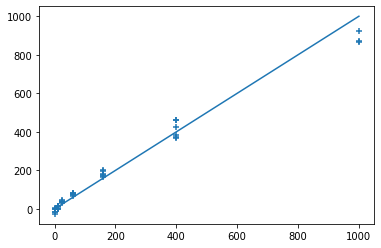

In [28]:
plt.scatter(y_test,y_pred,marker='+')
plt.plot([0,1000],[0,1000])

# Small data solution:
1. use simple model
2. emsemble method -- combine models from different clusters
    1. for instance, seperately build model on n clusters and combine the prediction result at the end
    2. further, do the iterative modeling -- take n features out from each cluster, build model, merge result, repeat the process
3. use less features for modeling -- only use the features that is representative for the clusters

this is especially useful in our case as most of the features within the same cluster should have strong collinearity
    
    strategy to reduce features in clusters:
    0. before reduction, need to verify the cluster is correctly seperated
    1. select features most close to the average (normalized average)
    2. select features at lower/upper/25%/50%/75% boundaries
    3. select features with highest intensity/lowest intensity
    
<font color = 'red'>4. get confidence interval rather than only a solid prediction result
